In [1]:
import sys
sys.path.append("C:\ZSOMBI\OneDrive\PoPy")
sys.path.append("/Users/zsombi/OneDrive/PoPy")
import os

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import xarray as xr
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_poisson_deviance
import time

from popy.io_tools import load_metadata
import popy.config as cfg
from popy.decoding.glms import SingleUnitAnalysis
from popy.plotting.plotting_tools import plot_keypoints

import matplotlib.pyplot as plt

def get_all_monkey_session():
    # get all session info
    session_metadata = load_metadata()
    session_metadata = session_metadata[session_metadata['block_len_valid'] == True]  # remove session with block_len_valid==False
    monkeys = session_metadata['monkey'].values
    sessions = session_metadata['session'].values
    return monkeys, sessions

ImportError: cannot import name 'build_dataset' from 'popy.decoding.population_decoders' (/Users/zsombi/ZSOMBI/SBRI/PoPy/popy/decoding/population_decoders.py)

In [2]:
grid_instance = {'model': 'value_glm_CPD',  # 'linear_correlation' or 'anova' or 'poisson_glm' or 'value_glm_CPD'
     'target_of_interest': None,
     'neural_data_type': 'spike_counts',  # 'firing_rate' or 'spike_counts'
     'value_type': None,  # 'discrete' or 'continuous'
     'glm_predictors': None,
     'cpd_full_model_predictors': ['last_fb', 'last_last_fb', 'last_last_last_fb', 'last_last_last_last_fb'],  # list of predictors used in the full model of the CPD analysis
     'cpd_reduced_model_predictors': ['last_fb'],  # list of predictors used in the reduced model of the CPD analysis (use list even if only one predictor)
     'step_time': .2,
     'area': None,
    }
monkey, session = 'ka', '210322'

glm = SingleUnitAnalysis(monkey, session)

for key, value in grid_instance.items():
    setattr(glm, key, value)
    

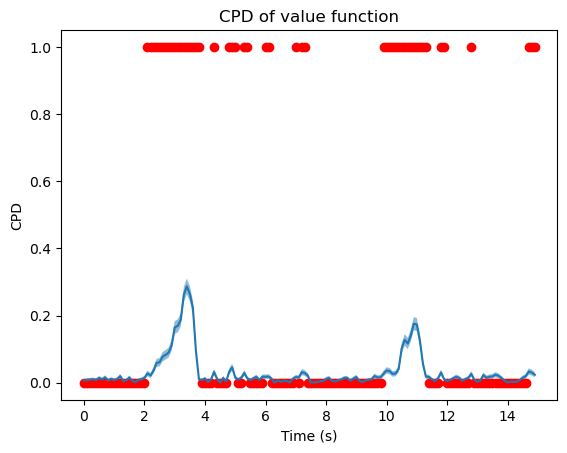

In [3]:
neural_dataset, predictors = glm.load_data_for_glm()  # load data, inits self.neural_dataset and self.predictors and self.unit_ids
unit_of_interest = 'MCC_12_01'
step_size = 10  # bins
time_vector = neural_dataset['time'].values[::step_size]

CPDs = np.empty(len(time_vector))
p_vals = np.empty(len(time_vector))
for t, time_of_interest in enumerate(time_vector):
    # get the target
    y_true = neural_dataset.sel(time=time_of_interest, unit=unit_of_interest)

    # get the predictors
    X_full = predictors[grid_instance['cpd_full_model_predictors']]
    X_full = sm.add_constant(X_full)
    X_reduced = predictors[grid_instance['cpd_reduced_model_predictors']]
    X_reduced = sm.add_constant(X_reduced)

    # fit the models
    model_full = sm.GLM(y_true, X_full, family=sm.families.Poisson()).fit()
    model_reduced = sm.GLM(y_true, X_reduced, family=sm.families.Poisson()).fit()

    # predict
    y_pred_full = model_full.predict(X_full)
    y_pred_reduced = model_reduced.predict(X_reduced)

    # calculate the deviance explained
    CPD = 1 - (mean_poisson_deviance(y_true, y_pred_full) / mean_poisson_deviance(y_true, y_pred_reduced))

    # print the results
    CPDs[t] = CPD

    # do random permutations
    n_perm = 10
    CPD_perm = np.zeros(n_perm)
    for i in range(n_perm):
        y_true_perm = np.random.permutation(y_true)
        model_full_perm = sm.GLM(y_true_perm, X_full, family=sm.families.Poisson()).fit()
        model_reduced_perm = sm.GLM(y_true_perm, X_reduced, family=sm.families.Poisson()).fit()
        y_pred_full_perm = model_full_perm.predict(X_full)
        y_pred_reduced_perm = model_reduced_perm.predict(X_reduced)
        CPD_perm[i] = 1 - (mean_poisson_deviance(y_true_perm, y_pred_full_perm) / mean_poisson_deviance(y_true_perm, y_pred_reduced_perm))

    # calculate the p-value
    p_value = np.sum(CPD_perm > CPD) / n_perm
    p_vals[t] = p_value
    
plt.plot(time_vector, CPDs)
plt.fill_between(time_vector, CPDs - 2*np.sqrt(CPDs*(1-CPDs)/neural_dataset['time'].size), CPDs + 2*np.sqrt(CPDs*(1-CPDs)/neural_dataset['time'].size), alpha=.5)
# mark significant points
plt.scatter(time_vector, p_vals < .05, color='red')
plt.xlabel('Time (s)')
plt.ylabel('CPD')
plt.title('CPD of value function')
plt.show()


In [4]:
glm.run()
res = glm.results

res

Running value_glm_CPD for ka - 210322...


<xarray.Dataset>
Dimensions:  (unit: 30, time: 74)
Coordinates:
  * unit     (unit) <U20 'ka_210322_LPFC_03_01' ... 'ka_210322_MCC_16_01'
  * time     (time) float64 0.0 0.2 0.4 0.6 0.81 ... 14.19 14.39 14.59 14.8
    monkey   (unit) <U2 'ka' 'ka' 'ka' 'ka' 'ka' ... 'ka' 'ka' 'ka' 'ka' 'ka'
    session  (unit) <U6 '210322' '210322' '210322' ... '210322' '210322'
    area     (unit) <U4 'LPFC' 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC' 'MCC' 'MCC'
    channel  (unit) <U2 '03' '04' '04' '04' '05' ... '13' '13' '14' '16' '16'
Data variables:
    scores   (unit, time) float64 0.06763 0.07034 0.0878 ... 0.00724 0.0294
    p_vals   (unit, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.66 0.83 0.43 0.01
Attributes:
    bin_size:                      0.01
    step_time:                     0.2
    area:                          None
    glm_predictors:                None
    cpd_full_model_predictors:     ['last_fb', 'last_last_fb', 'last_last_las...
    cpd_reduced_model_predictors:  ['last_fb']
    target_of_interest:            None
    model:                         value_glm_CPD
    model_scoring_function:        None
    neural_data_type:              spike_counts
    value_type:                    None

In [5]:
# convert attrs to string
for key, value in res.attrs.items():
    res.attrs[key] = str(value)
    
# save the results
res.to_netcdf('delete.nc')

In [6]:
res

<xarray.Dataset>
Dimensions:  (unit: 30, time: 74)
Coordinates:
  * unit     (unit) <U20 'ka_210322_LPFC_03_01' ... 'ka_210322_MCC_16_01'
  * time     (time) float64 0.0 0.2 0.4 0.6 0.81 ... 14.19 14.39 14.59 14.8
    monkey   (unit) <U2 'ka' 'ka' 'ka' 'ka' 'ka' ... 'ka' 'ka' 'ka' 'ka' 'ka'
    session  (unit) <U6 '210322' '210322' '210322' ... '210322' '210322'
    area     (unit) <U4 'LPFC' 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC' 'MCC' 'MCC'
    channel  (unit) <U2 '03' '04' '04' '04' '05' ... '13' '13' '14' '16' '16'
Data variables:
    scores   (unit, time) float64 0.06763 0.07034 0.0878 ... 0.00724 0.0294
    p_vals   (unit, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.66 0.83 0.43 0.01
Attributes:
    bin_size:                      0.01
    step_time:                     0.2
    area:                          None
    glm_predictors:                None
    cpd_full_model_predictors:     ['last_fb', 'last_last_fb', 'last_last_las...
    cpd_reduced_model_predictors:  ['last_fb']
    target_of_interest:            None
    model:                         value_glm_CPD
    model_scoring_function:        None
    neural_data_type:              spike_counts
    value_type:                    None

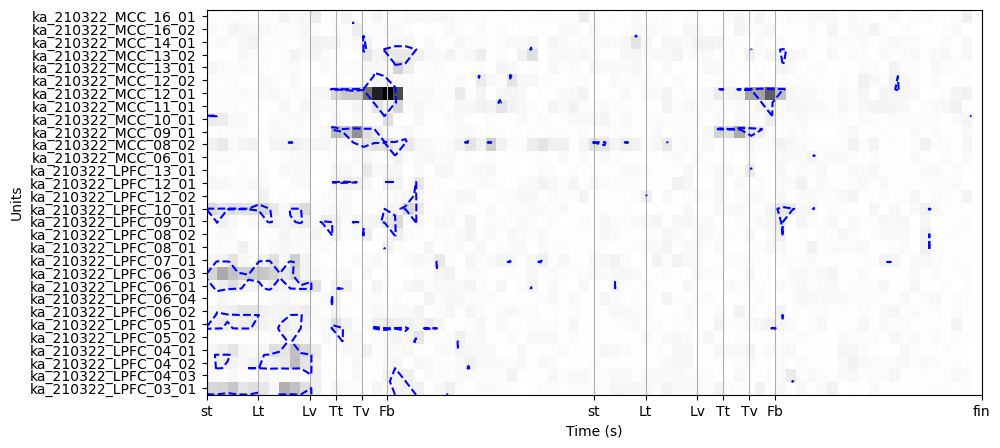

In [7]:
time_vector = res.time.data
unit_names = res.unit.data

scores_matrix = res.scores.data
pvals_matrix = res.p_vals.data

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(scores_matrix, aspect='auto', cmap='Greys', origin='lower', extent=[time_vector[0], time_vector[-1], -0.5, scores_matrix.shape[0]-.5])
# contour plot of p-values, fill with blue the unsignificant values
ax.contour(pvals_matrix, levels=[.01], colors='blue', linestyles='dashed', extent=[time_vector[0], time_vector[-1], -0.5, scores_matrix.shape[0]-.5])


ax.set_xlabel('Time (s)')
ax.set_ylabel('Units')

ax.set_xticks(np.arange(time_vector[0], time_vector[-1], 0.5))
ax.set_yticks(np.arange(0, scores_matrix.shape[0], 1))
ax.set_xticklabels(np.round(np.arange(time_vector[0], time_vector[-1], 0.5), 2))
ax.set_yticklabels(unit_names);

ax = plot_keypoints(ax)
ax.grid(axis='x')


Text(0.5, 1.0, 'Unit ka_210322_MCC_12_01')

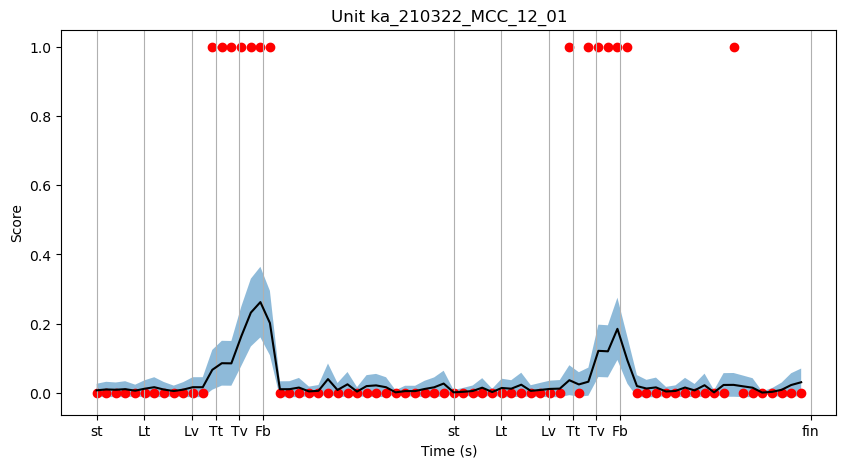

In [8]:
unit_id = 'ka_210322_MCC_12_01'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(time_vector, res.scores.sel(unit=unit_id), color='black')
ax.fill_between(time_vector, res.scores.sel(unit=unit_id) - 2*np.sqrt(res.scores.sel(unit=unit_id)*(1-res.scores.sel(unit=unit_id))/res.time.size), res.scores.sel(unit=unit_id) + 2*np.sqrt(res.scores.sel(unit=unit_id)*(1-res.scores.sel(unit=unit_id))/res.time.size), alpha=.5)
# mark significant points
ax.scatter(time_vector, res.p_vals.sel(unit=unit_id) < .00005, color='red')

ax = plot_keypoints(ax)
ax.grid(axis='x')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Score')
ax.set_title(f'Unit {unit_id}')

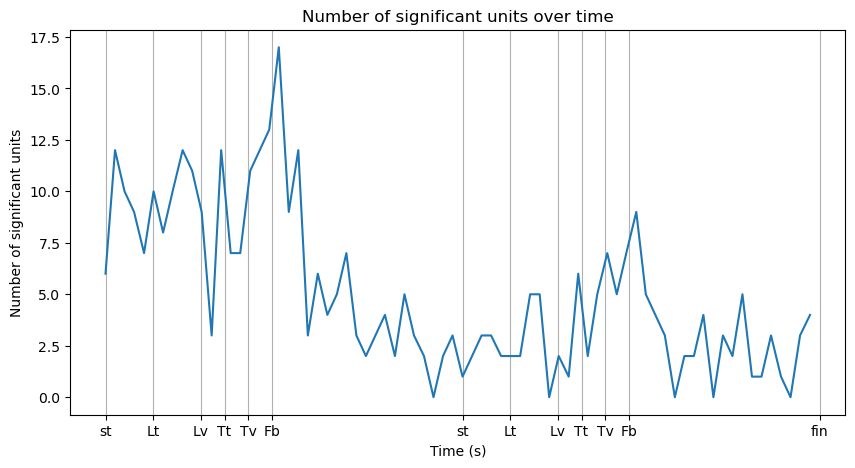

In [9]:
# plot number of significant units over time
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(time_vector, np.sum(res.p_vals < .05, axis=0))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Number of significant units')
ax.set_title('Number of significant units over time')
ax = plot_keypoints(ax)
ax.grid(axis='x')
plt.show()


In [10]:
res

<xarray.Dataset>
Dimensions:  (unit: 30, time: 74)
Coordinates:
  * unit     (unit) <U20 'ka_210322_LPFC_03_01' ... 'ka_210322_MCC_16_01'
  * time     (time) float64 0.0 0.2 0.4 0.6 0.81 ... 14.19 14.39 14.59 14.8
    monkey   (unit) <U2 'ka' 'ka' 'ka' 'ka' 'ka' ... 'ka' 'ka' 'ka' 'ka' 'ka'
    session  (unit) <U6 '210322' '210322' '210322' ... '210322' '210322'
    area     (unit) <U4 'LPFC' 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC' 'MCC' 'MCC'
    channel  (unit) <U2 '03' '04' '04' '04' '05' ... '13' '13' '14' '16' '16'
Data variables:
    scores   (unit, time) float64 0.06763 0.07034 0.0878 ... 0.00724 0.0294
    p_vals   (unit, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.66 0.83 0.43 0.01
Attributes:
    bin_size:                      0.01
    step_time:                     0.2
    area:                          None
    glm_predictors:                None
    cpd_full_model_predictors:     ['last_fb', 'last_last_fb', 'last_last_las...
    cpd_reduced_model_predictors:  ['last_fb']
    target_of_interest:            None
    model:                         value_glm_CPD
    model_scoring_function:        None
    neural_data_type:              spike_counts
    value_type:                    None